## Imports

In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt

file=uproot.open("run17_ch1.root")
file["IR02"].keys()



['ADC', 'Sampling', 'EventNumber', 'TriggerTimeStamp', 'PCTimeStamp']

## High #PE run 

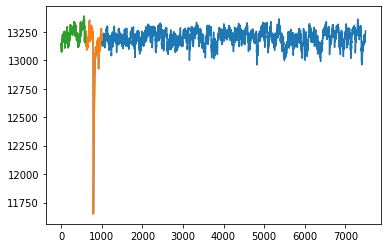

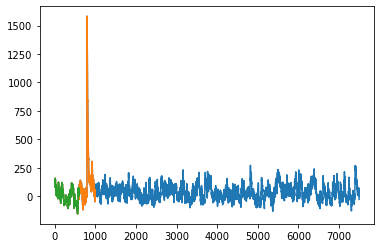

In [3]:
# Remove pedestal
WVF=file["IR02"]["ADC"].array().to_numpy()
ev=2;
PED_BINS=600
plt.plot(WVF[ev])
plt.plot(WVF[ev,:1000])
plt.plot(WVF[ev,:PED_BINS])

PED=np.mean(WVF[:,:PED_BINS],axis=1)
WVF=-(WVF-PED[:, np.newaxis])
plt.figure()
plt.plot(WVF[ev])
plt.plot(WVF[ev,:1000])
plt.plot(WVF[ev,:PED_BINS])


(0.0, 2647.718333333334)

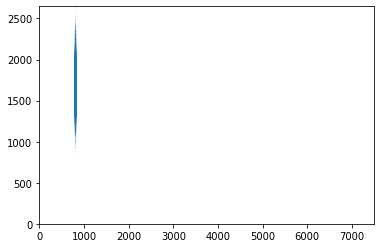

In [13]:
T_PEAK=np.argmax(WVF,axis=1)
A_PEAK=np.max(WVF,axis=1)
plt.plot(T_PEAK,A_PEAK,'.',markersize=0.1)
plt.xlim([0,len(WVF[0])])
plt.ylim([0,np.max(A_PEAK)])

In [40]:
def Av_WVF(WAVES):
    N_WAVES=len(WAVES);
    av_wvf=np.zeros(len(WAVES[0]))
    for wv in WAVES:
        av_wvf+=wv/N_WAVES;
    return av_wvf;

def Av_WVF_peak(WAVES,nbin_l=300,nbin_r=6000):
    N_WAVES=len(WAVES);
    av_wvf=np.zeros(nbin_l+nbin_r)
    for wv in WAVES:
        av_wvf+=wv[np.argmax(wv)-nbin_l:np.argmax(wv)+nbin_r]/N_WAVES;
    return av_wvf;

def Av_WVF_treshold(WAVES,threshold=500,nbin_l=300,nbin_r=6000):
    N_WAVES=len(WAVES);
    av_wvf=np.zeros(nbin_l+nbin_r)
    for wv in WAVES:
        bin=np.argwhere(wv>threshold)[0][0]
        av_wvf+=wv[bin-nbin_l:bin+nbin_r]/N_WAVES;
    return av_wvf;

av_wvf=Av_WVF(WVF)
av_wvf_2=Av_WVF_peak(WVF)
av_wvf_3=Av_WVF_treshold(WVF)

(10, 5000.0)

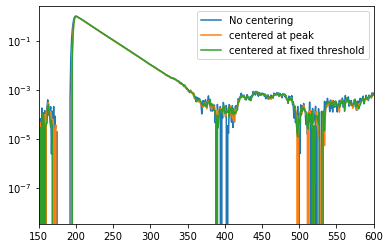

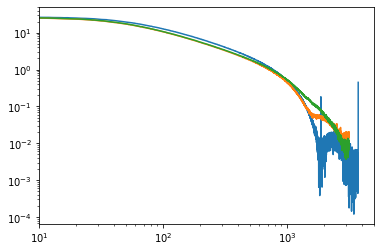

In [118]:
# No significative differences between them
%matplotlib inline
import scipy.fft as fft

plt.plot(av_wvf  [np.argmax(av_wvf)-200:np.argmax(av_wvf)+6000]  /max(av_wvf  ))
plt.plot(av_wvf_2[np.argmax(av_wvf_2)-200:np.argmax(av_wvf_2)+6000]/max(av_wvf_2))
plt.plot(av_wvf_3[np.argmax(av_wvf_3)-200:np.argmax(av_wvf_3)+6000]/max(av_wvf_3))
plt.semilogy()
plt.xlim([150,600])
plt.legend(["No centering","centered at peak","centered at fixed threshold"])

plt.figure()
plt.plot(np.abs(fft.rfft(av_wvf  /np.max(av_wvf  )) ))
plt.plot(np.abs(fft.rfft(av_wvf_2/np.max(av_wvf_2)) ))
plt.plot(np.abs(fft.rfft(av_wvf_3/np.max(av_wvf_3)) ))
plt.semilogx()
plt.semilogy()
plt.xlim([10,5e3])


## Calibration run

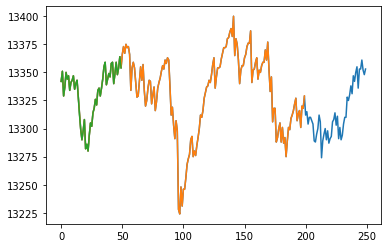

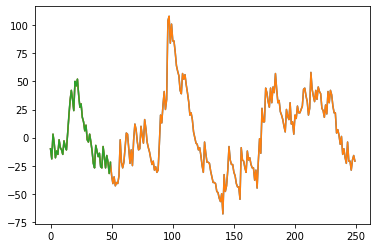

In [246]:
file=uproot.open("run09_ch1.root")

# Remove pedestal
WVF=file["IR02"]["ADC"].array().to_numpy()
ev=0;
PED_BINS=50
plt.plot(WVF[ev])
plt.plot(WVF[ev,:200])
plt.plot(WVF[ev,:PED_BINS])

PED=np.mean(WVF[:,:PED_BINS],axis=1)

WVF=-(WVF-PED[:, np.newaxis])
plt.figure()
plt.plot(WVF[ev])
plt.plot(WVF[ev,:1000])
plt.plot(WVF[ev,:PED_BINS])


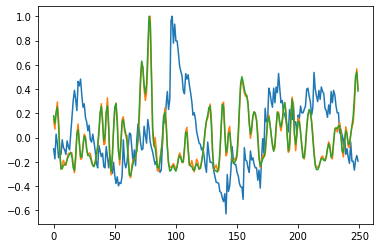

In [302]:
def make_GaussFilter(wvf,omega_cut=0.03,WVF_SIZE=250):
    # Creates a gauss filter with WVF size in the frequency domain with charactheristic frecency OMEGA_CUT in GHz
    gaus_f   =np.exp(- (np.arange(len(wvf))*0.25/WVF_SIZE/ omega_cut )**2)
    gaus_f[0]=0;
    return gaus_f;

gauss_f=make_GaussFilter(fft.rfft(WVF[0]))


def apply_filtering(wvf,dec=False,denominator=None):
    if dec: return fft.irfft(fft.rfft(wvf)*gauss_f/denominator)
    return fft.irfft(fft.rfft(wvf)*gauss_f)
# plt.plot(WVF[0])
denominator=fft.rfft( av_wvf[
            np.argmax(av_wvf)-20:
            np.argmax(av_wvf)+230]  )

denominator2=fft.rfft( av_wvf_2[
             np.argmax(av_wvf_2)-20:
             np.argmax(av_wvf_2)+230]  )

denominator3=fft.rfft( av_wvf_3[
             np.argmax(av_wvf_3)-20:
             np.argmax(av_wvf_3)+230]  )

# No difference in the dec approach either

ev=0
plt.plot(WVF[ev]/max(WVF[ev]))


# plt.plot(apply_filtering(WVF[ev])/np.max(apply_filtering(WVF[ev])))
# plt.plot(apply_filtering(WVF[ev],True,denominator)/np.max(apply_filtering(WVF[ev])))
plt.plot(apply_filtering(WVF[ev],True,denominator2)/np.max(apply_filtering(WVF[ev],True,denominator2)))
plt.plot(apply_filtering(WVF[ev],True,denominator3)/np.max(apply_filtering(WVF[ev],True,denominator3)))

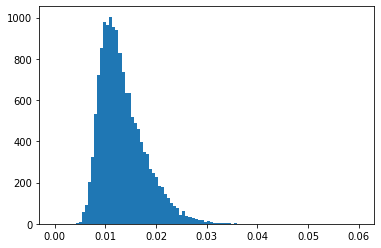

In [318]:
WVF_filtered=[]
for i in range(len(WVF)):
    WVF_filtered.append(fft.irfft(fft.rfft(WVF[i])*gauss_f/denominator3))

WVF_filtered=np.array(WVF_filtered)


PED_filtered=np.mean(WVF_filtered[:,:50],axis=1)
PED_STD     =np.std (WVF_filtered[:,:50],axis=1)

A_PEAK_filtered= np.max(WVF_filtered,axis=1)
# plt.hist(A_PEAK_filtered,2000,[0,0.06]);

# remove pedestal
WVF_filtered=WVF_filtered-PED_filtered[:, np.newaxis]
A_PEAK_filtered= np.max(WVF_filtered,axis=1)

# plt.hist(A_PEAK_filtered[PED_filtered<0.0005],2000,[0,0.06]);
# plt.hist(A_PEAK_filtered[PED_filtered<0.0002],2000,[0,0.06]);
plt.hist(A_PEAK_filtered[PED_STD<0.002],100,[0,0.06]);

# ev=18
# plt.plot(WVF[ev]/max(WVF[ev])/50)
# plt.plot(WVF_filtered[ev])

7

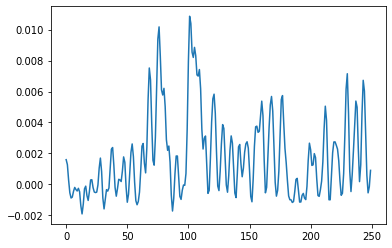

In [323]:
plt.plot(WVF_filtered[PED_STD<0.001][2])
len(WVF_filtered[PED_STD<0.001])
